### Unidad 5 Caso Práctico 1
# Juego de Datos MNIST

## Datos
Un tipo de datos muy habitual en ciencia de datos moderna son las imágenes. Basta con tratar cada píxel como un punto de datos y cada imagen como un caso.

Un conjunto de datos que ha sido utilizado como problema de referencia durante mucho tiempo es el conocido como MNIST Digits, que consiste en 7 000 imágenes de dígitos del cero al nueve, manuscritos.

Estas imágenes están preprocesadas para facilitar su utilización: todas están convertidas a blanco y negro, centradas, hechas más grandes o más pequeñas para que todas tengan el mismo tamaño, etc.

El problema típico que se aborda con este conjunto de datos es el de clasificación de imágenes: se trataría de identificar de qué dígito se trata en cada caso, a partir únicamente de los píxeles de la imagen. Para ello, se suministra, junto con las imágenes, el valor de referencia para cada dígito (obtenido mediante el consenso o la mayoría de opiniones sobre de qué digito se trata en cada caso, expresadas por voluntarios).

En este caso práctico no se va a realizar un modelo complejo de clasificación (que, aunque es una tarea propia de la ciencia de datos, no se recoge en esta unidad, sino en otras posteriores, más especializadas), pero si se va a manejar esa información para crear modelos triviales y comprobar su rendimiento.

## El Problema

1. Importar los datos de las imágenes de los dígitos MNIST y los datos de la clase a la que pertenece cada uno.
2. Realizar un análisis exploratorio de los datos. En concreto, preparar los datos para su utilización y visualizar ejemplos de dígitos y la clase a la que pertenece cada uno.
3. Para los dígitos cero y uno, crear un modelo de clasificación basado simplemente en el porcentaje horizontal de la imagen que tiene píxeles marcados (que debería ser menor en el caso de los unos, ya que son más “estrechos”).
4. Evaluar el rendimiento de ese clasificador mediante tablas de contingencia y cálculo de métricas habituales para problemas de este tipo.      
5. Generar la curva ROC de este modelo y calcular el AUC ROC.
6. Crear otro modelo de clasificación para los dígitos cero y uno basado en la cantidad de tinta utilizada en cada imagen, y compararlo con el primer modelo.


## Analizando una Solución
Este problema es complicado, ya que involucra utilizar un modelo heurístico para la solución. Antes que nada preparemos todas las librerias que son necesarias para resolver el problema. 

In [1]:
# Carga de las librerias relevantes para el programa
import pyarrow.parquet as pq
import numpy as np
import pandas as pd
from numpy.core._multiarray_umath import ndarray
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

Comencemos por la parte más sencilla del problema que es cargar los datos. 

In [2]:
# Open MNIST dataset with pixel files and class files.
# The data is stored as parquet files
image_set = pq.read_table('mnist_pixels.parquet')
image_set = image_set.to_pandas()

image_class = pq.read_table('mnist_clases.parquet')
image_class = image_class.to_pandas()
image_class = pd.to_numeric(image_class['class'])

Veamos un poco que hay adentro de cada estructura de datos. En teoría una es una matriz de datos con los valores de cada pixel, y la otra solamente un número que denota la clase. 

In [3]:
print(image_set.iloc[1])

pixel1      0.0
pixel2      0.0
pixel3      0.0
pixel4      0.0
pixel5      0.0
           ... 
pixel780    0.0
pixel781    0.0
pixel782    0.0
pixel783    0.0
pixel784    0.0
Name: 1, Length: 784, dtype: float64


Este formato no es muy interesante. Hay 784 posiciones, que es el resultado de 28 x 28 pixeles con valores que van del 0 al 255. El formato 28 x 28 pixeles es como vienen cortadas las imagenes que se procesan en el juego MNIST. Sería muy interesante poder ver como queda esto en una matriz de 28 x 28. Adicionalmente, como queremos medir densidad de cada matriz, basta con ver si hay valor o no, o sea 0 o 1. 

In [4]:
def transform_clean_format(image_set_instance):
    """Transform an image to a CLEAN_FORMAT, which is an image of 28x28 zeros or ones.
    This simplifies a lot calculating actual space used by a pic regardless or value.

    :parameter image_set_instance

    :return image_clean_format
    """
    temp = image_set_instance.to_list()
    temp2 = [1 if valores > 0 else 0 for valores in temp]
    image_clean_format: ndarray = np.reshape(temp2, (28, 28))
    return image_clean_format

print(transform_clean_format(image_set.iloc[1]))

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 

No solo funcionó muy bien, sino que a simple vista se puede ver que es un cero. Pero para estar seguro revisemos el valor real de la imagen en el juego de clases. 

In [5]:
print(image_class.iloc[1])

0


Un modelo de clasificación necesita parámetros. ¿Qué clasificamos como cero y qué clasificamos como uno? Teóricamente los 1 son más delgados y su densidad dentro de la matriz es menor que la de los 0, ya que ocupan menos espacio. Podemos calcular la densidad de cualquier imagen para ver si es 0 o 1. Pero antes, tenemos que poder discernir cual es la densidad promedio de todos los 1 y todos los 0. 

In [6]:
def calculate_horizontal_density(some_image_matrix):
    """Calculate the average pixel density for the 28 rows in an image matrix
    :parameter
    some_image_matrix

    :return
    row_density_counter
    """
    row_density_counter = []
    for rows in some_image_matrix:
        temp = sum(rows)/len(rows)
        row_density_counter.append(temp)
    return np.mean(row_density_counter)

Probemos el algoritmo con un solo número. 

In [7]:
print(calculate_horizontal_density(transform_clean_format(image_set.iloc[1])))

0.22448979591836735


Bien, por lo que vemos el 0 ocupa más o menos 0.22 de densidad. Automaticemos el análisis para obtener la densidad promedio de todos los 0 y todos los 1. 

In [8]:
def get_class_average_horizontal_density(image_set, class_set, target):
    """Get a target class, evaluate all elements, and return average
    horizontal density of row for that class

    :parameter image_set
    :parameter class_set
    :parameter target

    :return class_average_horizontal_density_list MEAN
    :return class_average_horizontal_density_list SD
    :return counter_evaluation
    """
    class_average_horizontal_density_list = []
    counter_evaluation = 0

    for i in range(1, len(image_set)):
        if (class_set[i] == target):
            reduced_image_set = transform_clean_format(image_set.iloc[i])
            temp = calculate_horizontal_density(reduced_image_set)
            class_average_horizontal_density_list.append(temp)
            counter_evaluation = counter_evaluation + 1

    return(np.mean(class_average_horizontal_density_list), np.std(class_average_horizontal_density_list), counter_evaluation)

# Evaluate average horizontal density for images of 0 and 1
print("Begin evaluation of images with class 1.")
results_1 = get_class_average_horizontal_density(image_set, image_class, 1)
print("Class Average Horizontal Density: ", results_1[0])
print("Class SD Horizontal Density: ", results_1[1])
print("Class Occurrences: ", results_1[2], "\n")

print("Begin evaluation of images with class 0.")
results_2 = get_class_average_horizontal_density(image_set, image_class, 0)
print("Class Average Horizontal Density: ", results_2[0])
print("Class SD Horizontal Density: ", results_2[1])
print("Class Occurrences: ", results_2[2], "\n")

Begin evaluation of images with class 1.
Class Average Horizontal Density:  0.1095654683099595
Class SD Horizontal Density:  0.025619148318372687
Class Occurrences:  7877 

Begin evaluation of images with class 0.
Class Average Horizontal Density:  0.24460545843717754
Class SD Horizontal Density:  0.0429571657861942
Class Occurrences:  6903 



## Un Modelo Heurístico
Un modelo simple puede ser evaluar todos los números 1 y 0. Uno estaría tentado a evaluar si el dígito está más cerca de la densidad promedio del 1 y el 0, pero para mejorar el modelo simplemente ampliemos a una cota superior e inferior con tres desviaciones estándar de forma de abarcar más. Dado la diferencia entre ambos promedios es relativamente grande, puede ser un buen punto de comienzo.

In [9]:
def density_classifier(image):
    """Simple classification model that analyzes if horizontal density of an image
    belongs to that trained for zeroes or ones. Function assumes that information in
    image is either one or zero, not any other number.

    :parameter image

    :return prediction
    """

    # Model parameters for ZERO classification
    zero_mean = 0.24460545843717754
    zero_sd = 0.0429571657861942
    zero_ub = zero_mean + (3 * zero_sd)
    zero_lb = zero_mean - (3 * zero_sd)

    # Model parameters for ONE classification
    one_mean = 0.1095654683099595
    one_sd = 0.025619148318372687
    one_ub = one_mean + (3 * one_sd)
    one_lb = one_mean - (3 * one_sd)

    temp = calculate_horizontal_density(image)
    prediction = 9
    if(temp >= zero_lb and temp < zero_ub): prediction = 0
    if(temp >= one_lb and temp < one_ub): prediction = 1
    return prediction

Dado que tenemos que poder medir la capacidad de nuestro modelo de identificar correctamente ceros y unos, también tengamos a mano una forma de extraer tablas de contingencia que automaticen el proceso. 

In [10]:
def make_contingency_table(y, y_hat):
    """Simple contingency table to record true positive, false negative, false positive,
    and true negative results of a classification model. Return everything neatly
    packaged as a dataframe ready for print.

    :parameter y_hat
    :parameter y

    :return df
    """
    tp, fn, fp, tn = 0,0,0,0
    for i in range(1, len(y)):
        if(y[i] == 1 and y_hat[i] == 1): tp = tp + 1
        if(y[i] == 0 and y_hat[i] == 1): fp = fp + 1
        if(y[i] == 1 and y_hat[i] == 0): fn = fn + 1
        if(y[i] == 0 and y_hat[i] == 0): tn = tn + 1
    dat = {'Positive': [tp, fp], 'Negative': [fn, tn]}
    df = pd.DataFrame(dat, columns=['Positive', 'Negative'], index=['Positive', 'Negative'])
    return(df)

Ahora con todos los elementos listos, creamos un lote de ejecución que itera por todo el juego de datos, y trata de clasificar ceros de unos. Por el momento ignoramos todo lo demás, ya que no agrega al caso.

In [11]:
# Create a test of all cases with 1 and 0 with classifier
pred_value = []
real_value = []
for i in range(1, len(image_class)):
    if (image_class.iloc[i] == 1 or image_class.iloc[i] == 0):
        real_value.append(image_class[i])
        temp = transform_clean_format(image_set.iloc[i])
        temp = density_classifier(temp)
        pred_value.append(temp)

print("Contingency Table Classifier\n")
print(make_contingency_table(real_value, pred_value))

# calculate auc scores
lr_auc = roc_auc_score(real_value, pred_value)
print("AUC Score for Model: ", lr_auc)

# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(real_value, pred_value)

Contingency Table Classifier

          Positive  Negative
Positive      7803        74
Negative       565      6313
AUC Score for Model:  0.9509181262225417


Nuestro modelo sencillo funcionó muy bien. Detectó 7,803 casos positivos (que eran 1) y solo 74 casos falsos positivos. A la vez clasificó correctamente 6,313 casos negativos (que eran 0) y solo 565 falsos negativos. El valor estimado de la AUC es de 0.95, ¡nada mal!

> Las porciones sobre curvas ROC y AUC fueron citadas de "How to Use ROC Curves and Precision-Recall Curves for Classification in Python", por Jason Brownlee (Agosto 31, 2018). El tutorial esta disponible en https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

## Visualización de Curvas ROC y AUC
Para poder visualizar la curva ROC, debemos por lo menos obtener los resultados de un punto más, el modelo __no skill__ que compara todo contra la probabilidad de 0.50. Comencemos por crear dicho modelo, sino no lo podemos llamar desde el bloque. 

In [12]:
def dumb_classifier(image):
    """Dumb classifier for base case of n = 0.5

    :parameter image

    :return prediction
    """

    temp = calculate_horizontal_density(image)
    prediction = 9
    if(temp >= 0.5): prediction = 0
    if(temp <  0.5): prediction = 1
    return prediction

Ahora que está creado, hagamos un bloque de prueba y veamos como queda la tabla de contingencia. 

In [13]:
# Create a test of all cases with 1 and 0 with no-skill classifier
pred_value = []
real_value = []
for i in range(1, len(image_class)):
    if (image_class.iloc[i] == 1 or image_class.iloc[i] == 0):
        real_value.append(image_class[i])
        temp = transform_clean_format(image_set.iloc[i])
        temp = dumb_classifier(temp)
        pred_value.append(temp)

print("Contingency Table Classifier No-Skill Classifier\n")
print(make_contingency_table(real_value, pred_value))

# calculate auc scores
ns_auc = roc_auc_score(real_value, pred_value)
print("AUC Score for Model: ", ns_auc)

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(real_value, pred_value)

Contingency Table Classifier No-Skill Classifier

          Positive  Negative
Positive      7877         0
Negative      6902         0
AUC Score for Model:  0.5


Nada especial con los resultados aquí. Nuestro modelo heurístico no es una probabilidad, por lo que el modelo __no skill__ simplemente clasificó todo lo que es mayor a 0.5 como 0 y todo lo menor que 0.5 como 1. Por lo tanto no clasificó nada como negativo (ningún valor de la lectura de densidad de la matriz de 28 x 28 pixeles es mayor a 0.50 en nuestro caso). El AUC nos da 0.5, que no nos debe extrañar ya que es justamente la recta de 45 grados. Lo único bueno de esto es que podemos ahora comparar los dos para una gráfica de AUC.

No hemos hecho la gráfica a mano, sino que utilizamos las funciones de __SciKit__ `roc_curve` para tal fin. Solo pasamos los juegos de datos con los valores reales y los valores de predicción, y la función nos devuelve de forma automática el valor FALSE POSITIVE RATE y TRUE POSITIVE RATE.

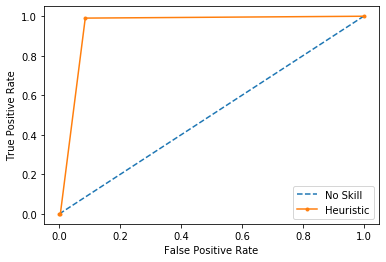

In [14]:
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Heuristic')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

## Un Modelo Alterno
Para terminar el caso práctico se pide crear otro modelo de clasificación para los dígitos cero y uno basado en la cantidad de tinta utilizada en cada imagen, y compararlo con el primer modelo.

En el primer problema transformabamos cada imagen en una matriz de 28 X 28 con ceros o unos, eliminando el valor del pixel. Para este modelo, mantengamos el valor del pixel como el valor original del pixel y veamos como se ve. 

In [25]:
def transform_ink_format(image_set_instance):
    """Transform an image to a CLEAN_FORMAT, which is an image of 28x28 with real pixel
    value. This simplifies calculating heuristics when reading ink levels.

    :parameter image_set_instance

    :return image_clean_format
    """
    temp = image_set_instance.to_list()
    image_clean_format: ndarray = np.reshape(temp, (28, 28))
    return image_clean_format

Esta vez, en vez de densidad de pixeles (menos igual un 1, más igual un 0) estamos evaluando la tinta que se usa. Para construir un modelo debieramos correr todo el juego y obtener valores promedios de tinta para cada dígito. Necesitamos entonces una función adicional (que calcule el uso de tinta) y un pequeño _script_ que ejecute el lote.

In [16]:
def calculate_ink_density(some_image_matrix):
    """Calculate the average pixel ink density for the 28 rows in an image matrix
    :parameter
    some_image_matrix

    :return
    row_density_counter
    """
    row_ink_density_counter = []
    for rows in some_image_matrix:
        temp = sum(rows)/len(rows)
        row_ink_density_counter.append(temp)
    return np.mean(row_ink_density_counter)



Automaticemos el proceso de calcular la densidad de tinta como hicimos con el primer ejemplo.

In [17]:
def get_class_average_ink_density(image_set, class_set, target):
    """Get a target class, evaluate all elements, and return average
    ink density of row for that class

    :parameter image_set
    :parameter class_set
    :parameter target

    :return class_average_horizontal_density_list MEAN
    :return class_average_horizontal_density_list SD
    :return counter_evaluation
    """
    class_average_ink_density_list = []
    counter_evaluation = 0

    for i in range(1, len(image_set)):
        if (class_set[i] == target):
            reduced_image_set = transform_ink_format(image_set.iloc[i])
            temp = calculate_ink_density(reduced_image_set)
            class_average_ink_density_list.append(temp)
            counter_evaluation = counter_evaluation + 1

    return(np.mean(class_average_ink_density_list), np.std(class_average_ink_density_list), counter_evaluation)

# Evaluate average horizontal density for images of 0 and 1
print("Begin evaluation of images with class 1.")
results_1 = get_class_average_ink_density(image_set, image_class, 1)
print("Class Average Horizontal Density: ", results_1[0])
print("Class SD Horizontal Density: ", results_1[1])
print("Class Occurrences: ", results_1[2], "\n")

print("Begin evaluation of images with class 0.")
results_2 = get_class_average_ink_density(image_set, image_class, 0)
print("Class Average Horizontal Density: ", results_2[0])
print("Class SD Horizontal Density: ", results_2[1])
print("Class Occurrences: ", results_2[2], "\n")

Begin evaluation of images with class 1.
Class Average Horizontal Density:  19.40680177110834
Class SD Horizontal Density:  5.652097783811537
Class Occurrences:  7877 

Begin evaluation of images with class 0.
Class Average Horizontal Density:  44.17740512110972
Class SD Horizontal Density:  10.788824931073156
Class Occurrences:  6903 



Con estos datos ya podemos programar un modelo heurístico que defina en base a la cantidad de tinta si la imagen es un uno o un cero.

In [19]:
def ink_classifier(image):
    """Simple classification model that analyzes if ink usage of an image
    belongs to that trained for zeroes or ones. Function assumes that information in
    image is either one or zero, not any other number.

    :parameter image

    :return prediction
    """

    # Model parameters for ZERO classification
    zero_mean = 44.17740512110972
    zero_sd = 10.788824931073156
    zero_ub = zero_mean + (3 * zero_sd)
    zero_lb = zero_mean - (3 * zero_sd)

    # Model parameters for ONE classification
    one_mean = 19.40680177110834
    one_sd = 5.652097783811537
    one_ub = one_mean + (3 * one_sd)
    one_lb = one_mean - (3 * one_sd)

    temp = calculate_horizontal_density(image)
    prediction = 9
    if(temp >= zero_lb and temp < zero_ub): prediction = 0
    if(temp >= one_lb and temp < one_ub): prediction = 1
    return prediction

Finalmente, pongamos el modelo bajo escrutinio.

In [22]:
# Create a test of all cases with 1 and 0 with ink classifier
pred_value = []
real_value = []
for i in range(1, len(image_class)):
    if (image_class.iloc[i] == 1 or image_class.iloc[i] == 0):
        real_value.append(image_class[i])
        temp = transform_ink_format(image_set.iloc[i])
        temp = ink_classifier(temp)
        pred_value.append(temp)

print("Contingency Table Classifier\n")
print(make_contingency_table(real_value, pred_value))

# calculate auc scores
ink_auc = roc_auc_score(real_value, pred_value)
print("AUC Score for Model: ", ink_auc)

# calculate roc curves
ink_fpr, ink_tpr, _ = roc_curve(real_value, pred_value)

Contingency Table Classifier

          Positive  Negative
Positive      7797        80
Negative      1685      5187
AUC Score for Model:  0.8685496722745267


El valor de AUC del modelo de tinta es 0.8685496722745267, inferior al modelo más sencillo de matriz por densidad de 0.9509181262225417. Podemos ahora visualizar la curva ROC.

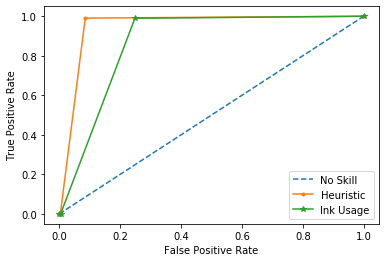

In [24]:
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Heuristic')
pyplot.plot(ink_fpr, ink_tpr, marker='*', label='Ink Usage')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()